<a href="https://colab.research.google.com/github/shaunhyp57/Artificial-Intelligence-Machine-Learning/blob/master/HW_4/HW4_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Xception

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 12:40:20--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c0a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   127MB/s    in 0.5s    

2020-04-21 12:40:20 (127 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with ResNet50 convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception

# Change to another one!!
# conv_base = VGG16(
#     weights='imagenet', 
#     include_top=False, 
#     input_shape=(150, 150, 3))

conv_base = Xception(
      weights = 'imagenet',
      include_top = False,
      input_shape = (150, 150, 3))

83689472/83683744 [==============================] - 2s 0us/step


In [5]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 47,207,977
Trainable params: 26,346,497
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 20s 201ms/step - loss: 0.2348 - acc: 0.8915 - val_loss: 0.1140 - val_acc: 0.9580
Epoch 2/30
100/100 [==============================] - 19s 194ms/step - loss: 0.1625 - acc: 0.9335 - val_loss: 0.0986 - val_acc: 0.9620
Epoch 3/30
100/100 [==============================] - 20s 197ms/step - loss: 0.1708 - acc: 0.9320 - val_loss: 0.1020 - val_acc: 0.9640
Epoch 4/30
100/100 [==============================] - 20s 197ms/step - loss: 0.1383 - acc: 0.9430 - val_loss: 0.1159 - val_acc: 0.9590
Epoch 5/30
100/100 [==============================] - 20s 197ms/step - loss: 0.1485 - acc: 0.9405 - val_loss: 0.0852 - val_acc: 0.9640
Epoch 6/30
100/100 [==============================] - 20s 198ms/step - loss: 0.1390 - acc: 0.9480 - val_loss: 0.0862 - val_acc: 0.9670
Epoch 7/30
100/100 [==========

## Display curves of loss and accuracy during training

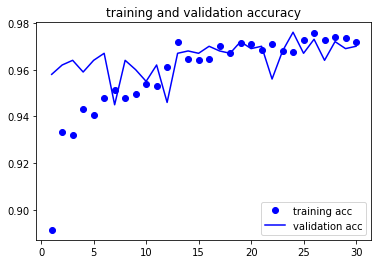

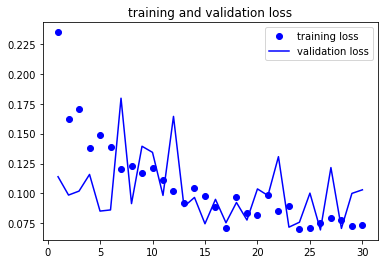

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block14_sepconv2_bn':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [15]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 21s 208ms/step - loss: 0.0901 - acc: 0.9660 - val_loss: 0.0844 - val_acc: 0.9700
Epoch 2/100
100/100 [==============================] - 20s 204ms/step - loss: 0.0920 - acc: 0.9685 - val_loss: 0.0602 - val_acc: 0.9790
Epoch 3/100
100/100 [==============================] - 20s 203ms/step - loss: 0.0888 - acc: 0.9685 - val_loss: 0.0946 - val_acc: 0.9670
Epoch 4/100
100/100 [==============================] - 21s 207ms/step - loss: 0.0904 - acc: 0.9635 - val_loss: 0.0775 - val_acc: 0.9730
Epoch 5/100
100/100 [==============================] - 20s 202ms/step - loss: 0.0737 - acc: 0.9730 - val_loss: 0.1002 - val_acc: 0.9630
Epoch 6/100
100/100 [==============================] - 20s 200ms/step - loss: 0.0728 - acc: 0.9755 - val_loss: 0.0694 - val_acc: 0.9730
Epoch 7/100
100/100 [==============================] - 20s 199ms/step - loss: 0.0906 - acc: 0.9675 - val_loss: 0.0688 - val_acc: 0.9780
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

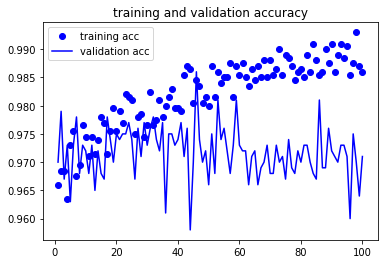

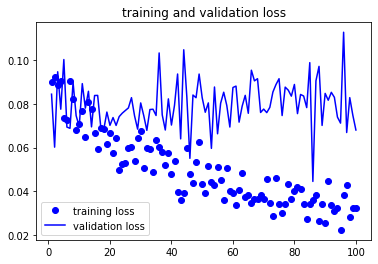

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. The model is not a good model, as there is variance when using the model to predict the activation set.

## Print out validation loss and accuracy

In [18]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [19]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.06774970889091492
Validation accuracy: 0.9760000109672546


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)